In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

# Import Data

In [2]:
! pip install -q kaggle
! mkdir -p ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d cicdataset/cicids2017

 91% 209M/230M [00:01<00:00, 175MB/s]
100% 230M/230M [00:01<00:00, 202MB/s]


In [4]:
! unzip -q /content/cicids2017.zip

In [5]:
import os
csv_files = []
for dirname, _, filenames in os.walk('/content/MachineLearningCSV/MachineLearningCVE'):
    for filename in filenames:
        csv_file = os.path.join(dirname, filename)
        print(os.path.join(dirname, filename))
        csv_files.append(csv_file)

/content/MachineLearningCSV/MachineLearningCVE/Friday-WorkingHours-Morning.pcap_ISCX.csv
/content/MachineLearningCSV/MachineLearningCVE/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
/content/MachineLearningCSV/MachineLearningCVE/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
/content/MachineLearningCSV/MachineLearningCVE/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
/content/MachineLearningCSV/MachineLearningCVE/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
/content/MachineLearningCSV/MachineLearningCVE/Monday-WorkingHours.pcap_ISCX.csv
/content/MachineLearningCSV/MachineLearningCVE/Tuesday-WorkingHours.pcap_ISCX.csv
/content/MachineLearningCSV/MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv


In [6]:
df = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)
df.columns = df.columns.str.strip()
print("original length of df:", len(df))
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
print("after droping null values, the length of df:", len(df))

original length of df: 2830743
after droping null values, the length of df: 2827876


In [7]:
df.shape

(2827876, 79)

# Data Preprocessing

In [8]:
df.Label.value_counts()

BENIGN                        2271320
DoS Hulk                       230124
PortScan                       158804
DDoS                           128025
DoS GoldenEye                   10293
FTP-Patator                      7935
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1956
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: Label, dtype: int64

In [9]:
# merg DoS attacks in one name
data = df.copy()
data.Label.replace(["DoS GoldenEye", "DoS Hulk", "DoS Slowhttptest", "DoS slowloris"], "DoS", inplace=True)
data.Label.value_counts()

BENIGN                        2271320
DoS                            251712
PortScan                       158804
DDoS                           128025
FTP-Patator                      7935
SSH-Patator                      5897
Bot                              1956
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: Label, dtype: int64

In [10]:
# Put DoS and benign in new data
dos = data.loc[data['Label'] == 'DoS']
bengin = data.loc[data['Label'] == 'BENIGN']

In [11]:
data = dos.append(bengin)

In [12]:
# Encode label in data
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['Label'] = le.fit_transform(data['Label'])

In [13]:
# scale data 
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

In [14]:
# select train and test data
from sklearn.model_selection import train_test_split
x = data[:, 0:78]
y = data[:, 78:79]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=4)

In [15]:
x_train.shape, y_train.shape, x_test.shape

((2018425, 78), (2018425, 1), (504607, 78))

In [16]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# MLP Model 

In [17]:
# Bild MLP model 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
model = Sequential()
model.add(Dense(input_shape=(78,), units=128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(2, activation='softmax'))

In [18]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')

In [19]:
history = model.fit(x_train, y_train, batch_size=512, epochs=5, validation_data=(x_test, y_test))

Epoch 1/5
3943/3943 [==============================] - 17s 4ms/step - loss: 0.0312 - accuracy: 0.9876 - val_loss: 0.0142 - val_accuracy: 0.9938
Epoch 2/5
3943/3943 [==============================] - 14s 3ms/step - loss: 0.0161 - accuracy: 0.9928 - val_loss: 0.0132 - val_accuracy: 0.9934
Epoch 3/5
3943/3943 [==============================] - 15s 4ms/step - loss: 0.0150 - accuracy: 0.9931 - val_loss: 0.0119 - val_accuracy: 0.9940
Epoch 4/5
3943/3943 [==============================] - 16s 4ms/step - loss: 0.0150 - accuracy: 0.9929 - val_loss: 0.0113 - val_accuracy: 0.9940
Epoch 5/5
3943/3943 [==============================] - 13s 3ms/step - loss: 0.0143 - accuracy: 0.9928 - val_loss: 0.0127 - val_accuracy: 0.9936


In [20]:
model.evaluate(x_test, y_test)

15769/15769 [==============================] - 34s 2ms/step - loss: 0.0127 - accuracy: 0.9936


[0.01271545048803091, 0.9936286807060242]

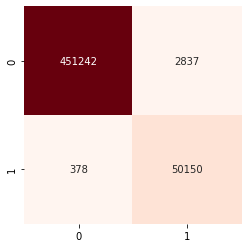

In [21]:
from sklearn.metrics import confusion_matrix
from numpy import argmax 
import seaborn as sns
y_test_pred = model.predict(x_test)
y_pred = []
for i in range(len(y_test_pred)):
  y_pred.append(argmax(y_test_pred[i]))
y_test_ = []
for i in range(len(y_test)):
  y_test_.append(argmax(y_test[i]))
conf_mat = confusion_matrix(y_test_, y_pred)
sns.heatmap(conf_mat, square=True, annot=True, cmap='Reds', fmt='d', cbar=False)

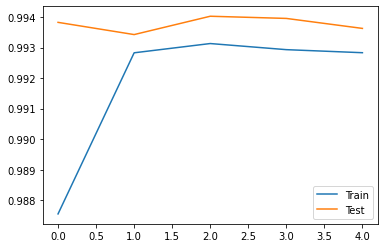

In [22]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.legend()

In [26]:
history.history['val_accuracy']

[0.9938268661499023,
 0.9934265613555908,
 0.9940270185470581,
 0.993955671787262,
 0.9936286807060242]